In [1]:
import torch
from torch import nn
import tools
import math
import collections
import time

In [2]:
def masksoftmax(x, valid_len=None):
    if valid_len is None:
        return nn.functional.softmax(x, dim=-1)
    else:
        shape = x.shape
        if valid_len.dim() == 1:
            valid_len = torch.repeat_interleave(valid_len, shape[1])
        else:
            valid_len = valid_len.reshape(-1)
        x = x.reshape(-1, shape[-1])
        mask = torch.arange(shape[-1], device=x.device)[None, :] < valid_len[:, None]
        x[~mask] = -1e6
        return nn.functional.softmax(x.reshape(shape), dim=-1)

In [3]:
def transpose_input(x, num_heads):
    shape = x.shape
    x = x.reshape(shape[0], shape[1], num_heads, -1)
    x = x.permute(0, 2, 1, 3)
    return x.reshape(-1, x.shape[2], x.shape[3])

In [4]:
def transpose_output(x, num_heads):
    shape = x.shape
    x = x.reshape(-1, num_heads, shape[1], shape[-1])
    x = x.permute(0, 2, 1, 3)
    return x.reshape(x.shape[0], shape[1], -1)

In [5]:
class DotproductAttention(nn.Module):
    def __init__(self):
        super(DotproductAttention, self).__init__()
    def forward(self, q, k, v, valid_len):
        d_k = q.shape[-1]
        score = torch.bmm(q, k.transpose(2, 1))/math.sqrt(d_k)
        attention_weights = masksoftmax(score, valid_len)
        return torch.bmm(attention_weights, v)

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, q_size, k_size, v_size, num_heads, num_hidden):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.attention = DotproductAttention()
        self.q_affine = nn.Linear(q_size, num_hidden)
        self.k_affine = nn.Linear(k_size, num_hidden)
        self.v_affine = nn.Linear(v_size, num_hidden)
        self.out_affine = nn.Linear(num_hidden, num_hidden)
    def forward(self, q, k, v, valid_len):
        if valid_len is not None:
            valid_len = torch.repeat_interleave(valid_len, self.num_heads, dim=0)
        q = transpose_input(self.q_affine(q), self.num_heads)
        k = transpose_input(self.k_affine(k), self.num_heads)
        v = transpose_input(self.v_affine(v), self.num_heads)
        output = self.attention(q, k, v, valid_len)
        concat = transpose_output(output, self.num_heads)
        return self.out_affine(concat)

In [7]:
class FeedForward(nn.Module):
    def __init__(self, q_size, ff_hidden_dim):
        super(FeedForward, self).__init__()
        self.linear_1 = nn.Linear(q_size, ff_hidden_dim)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(ff_hidden_dim, q_size)
    def forward(self, x):
        return self.linear_2(self.relu(self.linear_1(x)))

In [8]:
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout):
        super(AddNorm, self).__init__()
        self.norm = nn.LayerNorm(normalized_shape)
        self.dropout = nn.Dropout(dropout)
    def forward(self, layer_input, layer_output):
        return self.norm(layer_input + self.dropout(layer_output))

In [9]:
class EncoderBlock(nn.Module):
    def __init__(self, q_size, k_size, v_size, num_heads, num_hidden, normalized_shape, dropout, ff_hidden_dim):
        super(EncoderBlock, self).__init__()
        self.multiheadattention = MultiHeadAttention(q_size, k_size, v_size, num_heads, num_hidden)
        self.ff = FeedForward(q_size, ff_hidden_dim)
        self.addnorm1 = AddNorm(normalized_shape, dropout)
        self.addnorm2 = AddNorm(normalized_shape, dropout)
    def forward(self, x, valid_len):
        y = self.multiheadattention(x, x, x, valid_len)
        y1 = self.addnorm1(x, y)
        y2 = self.ff(y1)
        return self.addnorm2(y1, y2)

In [10]:
class EN_PositionalEncoding(nn.Module):
    def __init__(self, max_len, hidden_dim, dropout, vocab_size_en):
        super(EN_PositionalEncoding, self).__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout)
        self.embedding = nn.Embedding(vocab_size_en, self.hidden_dim)
        self.pos = torch.zeros((1, max_len, self.hidden_dim))
        para = torch.arange(max_len).reshape(-1, 1) / torch.pow(10000, torch.arange(0, self.hidden_dim, 2) / self.hidden_dim)
        self.pos[:, :, 0::2] = torch.sin(para)
        self.pos[:, :, 1::2] = torch.cos(para)
    def forward(self, x):
        x = self.embedding(x) * math.sqrt(self.hidden_dim) + self.pos.to(x.device)
        return self.dropout(x)

In [11]:
class DE_PositionalEncoding(nn.Module):
    def __init__(self, vocab_vector_matrix_de, max_len, hidden_dim_embed, dropout, vocab_size_de):
        super(DE_PositionalEncoding, self).__init__()
        self.hidden_dim_embed = hidden_dim_embed 
        self.dropout = nn.Dropout(dropout)
        self.embedding = nn.Embedding(vocab_size_de, self.hidden_dim_embed, _weight=vocab_vector_matrix_de)
        self.pos = torch.zeros((1, max_len, self.hidden_dim_embed))
        para = torch.arange(max_len).reshape(-1, 1) / torch.pow(10000, torch.arange(0, self.hidden_dim_embed, 2) / self.hidden_dim_embed)
        self.pos[:, :, 0::2] = torch.sin(para)
        self.pos[:, :, 1::2] = torch.cos(para)
    def forward(self, x):
        x = self.embedding(x) * math.sqrt(self.hidden_dim_embed) + self.pos[:, :x.shape[1], :].to(x.device)
        return self.dropout(x)

In [12]:
class TransformerEncoder(nn.Module):
    def __init__(self, max_len, num_layers, vocab_size_en, hidden_dim_embed, q_size, k_size, v_size, num_heads, num_hidden_attention, normalized_shape, dropout, ff_hidden_dim):
        super(TransformerEncoder, self).__init__()
        self.positional_embedding = EN_PositionalEncoding(max_len, hidden_dim_embed, dropout, vocab_size_en)
        self.blocks = nn.Sequential()
        for i in range(num_layers):
            self.blocks.add_module('block' + str(i),EncoderBlock(q_size, k_size, v_size, num_heads, num_hidden_attention, normalized_shape, dropout, ff_hidden_dim))
    def forward(self, x, valid_len):
        x = self.positional_embedding(x)
        for block in self.blocks:
            x = block(x, valid_len)
        return x

In [13]:
class DecoderBlock(nn.Module):
    def __init__(self, q_size, k_size, v_size, num_heads, num_hidden_attention, normalized_shape, dropout,ff_hidden_dim, i):
        super(DecoderBlock, self).__init__()
        self.attention1 = MultiHeadAttention(q_size, k_size, v_size, num_heads, num_hidden_attention)
        self.addnorm1 = AddNorm(normalized_shape, dropout)
        self.attention2 = MultiHeadAttention(q_size, k_size, v_size, num_heads, num_hidden_attention)
        self.addnorm2 = AddNorm(normalized_shape, dropout)
        self.feedforward = FeedForward(q_size, ff_hidden_dim)
        self.addnorm3 = AddNorm(normalized_shape, dropout)
        self.i = i
    def forward(self, decoder_input, state):
        encoder_output, encoder_validlen = state[0], state[1]
        if self.training:
            batch_size, max_len, _ = decoder_input.shape
            decoder_validlen = torch.arange(1, 1 + max_len, device=decoder_input.device).repeat(batch_size, 1)
        else:
            decoder_validlen = None
        if state[2][self.i] == None:
            k = decoder_input
        else:
            k = torch.cat((state[2][self.i], decoder_input), dim=1)
        state[2][self.i] = k
        x2 = self.attention1(decoder_input, k, k, decoder_validlen)
        x2 = self.addnorm1(decoder_input, x2)
        x3 = self.attention2(x2, encoder_output, encoder_output, encoder_validlen)
        x3 = self.addnorm2(x2, x3)
        return self.addnorm3(x3, self.feedforward(x3)), state

In [14]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_vector_matrix_de, q_size, k_size, v_size, num_heads, num_hidden_attention, normalized_shape, dropout, ff_hidden_dim, num_layers, vocab_size_de, hidden_dim_embed):
        super(TransformerDecoder, self).__init__()
        self.num_heads = num_heads
        self.positional_embedding = DE_PositionalEncoding(vocab_vector_matrix_de, max_len, hidden_dim_embed, dropout, vocab_size_de)
        self.blocks = nn.Sequential()
        self.num_layers = num_layers
        for i in range(num_layers):
            self.blocks.add_module('block' + str(i),DecoderBlock(q_size, k_size, v_size, num_heads, num_hidden_attention, normalized_shape, dropout, ff_hidden_dim, i))
        self.linearmatrix = vocab_vector_matrix_de
    def init_state(self, enc_output, enc_valid_len):
        return [enc_output, enc_valid_len, [None] * self.num_layers]
    def forward(self, dec_input, state):
        x = self.positional_embedding(dec_input)
        for blk in self.blocks:
            x, state = blk(x, state)
        return torch.matmul(x, self.linearmatrix.transpose(1, 0)), state

In [15]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, encoder_input, encoder_valid_len, decoder_input):
        encoder_output = self.encoder(encoder_input, encoder_valid_len)
        decoder_state = self.decoder.init_state(encoder_output, encoder_valid_len)
        return self.decoder(decoder_input, decoder_state)

In [16]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        max_len = weights.shape[1]
        mask = torch.arange(max_len, device=label.device)[None, :] < valid_len[: , None]
        weights[~mask] = 0
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).sum(dim=1)
        return weighted_loss

In [17]:
def bleu(pred_seq, label_seq):
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, len_pred + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        if num_matches == 0:
            return score
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [18]:
max_len = 10; num_layers = 2; batch_size = 32
hidden_dim_embed = 32; q_size = 32; k_size = 32; v_size = 32; num_heads = 4
num_hidden_attention = 32; normalized_shape = [32]; dropout = 0.1; ff_hidden_dim = 64
device = 'cuda'

In [19]:
train_iter, src_vocab, tgt_vocab = tools.load_data_nmt(batch_size, max_len)

In [20]:
vocab_size_en = len(src_vocab); vocab_size_de= len(tgt_vocab)

In [21]:
vocab_vector_matrix_de = nn.Parameter(torch.rand(vocab_size_de, hidden_dim_embed))

In [22]:
encoder = TransformerEncoder(max_len, num_layers, vocab_size_en, hidden_dim_embed, q_size, k_size, v_size, num_heads, num_hidden_attention, normalized_shape, dropout, ff_hidden_dim)

In [23]:
decoder = TransformerDecoder(vocab_vector_matrix_de, q_size, k_size, v_size, num_heads, num_hidden_attention, normalized_shape, dropout, ff_hidden_dim, num_layers, vocab_size_de, hidden_dim_embed)

In [24]:
net = EncoderDecoder(encoder, decoder)

In [25]:
loss = MaskedSoftmaxCELoss()

In [26]:
def trainer(net, loss, epochs, train_iter, tgt_vocab, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
    optimizer = torch.optim.Adam(net.parameters(), lr = lr )
    net.apply(init_weights)
    net.to(device=device)
    net.train()
    animator = tools.Animator(xlabel='epoch', ylabel='loss',xlim=[4,epochs])
    for i in range(epochs):
        start = time.time()
        l_accum = 0.0
        batch_token_num_accum = 0
        for batch in train_iter:
            enc_in, enc_len, dec_in, dec_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * dec_in.shape[0], device=device).reshape(-1, 1)
            y = torch.cat([bos, dec_in[:, :-1]], 1)
            y_hat, _ = net(enc_in, enc_len, y)
            l = loss(y_hat, dec_in, dec_len)
            optimizer.zero_grad()
            l.sum().backward()
            optimizer.step()
            with torch.no_grad():
                batch_token_num_accum += float(dec_len.sum())
                l_accum += float(l.sum())
        end = time.time()
        animator.add(i + 1, (l_accum / batch_token_num_accum,))
    print(f'loss: {l_accum / batch_token_num_accum:.3f}')
    print(f'speed: {batch_token_num_accum / (end - start):.1f} tokens per sec on {device}')

loss: 0.316
speed: 5710.9 tokens per sec on cuda


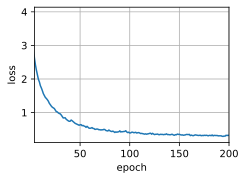

In [27]:
trainer(net, loss, 200, train_iter, tgt_vocab, 0.005, device)

In [28]:
def predict(net, sentences, src_vocab, tgt_vocab, num_steps):
    net.eval()
    sentences = src_vocab[sentences.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(sentences)], device=device)
    sentences = sentences + [src_vocab['<pad>']] * (num_steps - len(sentences))
    enc_input = torch.unsqueeze(torch.tensor(sentences, device=device), dim = 0)
    enc_output = net.encoder(enc_input, enc_valid_len)
    dec_state = net.decoder.init_state(enc_output, enc_valid_len)
    dec_x = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], device=device), dim=0)
    seq_output =[]
    for _ in range(num_steps):
        y, dec_state = net.decoder(dec_x, dec_state)
        dec_x = y.argmax(dim=2)
        pre = dec_x.squeeze(dim=0).item()
        if pre == tgt_vocab['<eos>']:
            break
        seq_output.append(pre)
    return ' '.join(tgt_vocab.to_tokens(seq_output))

In [29]:
sentences =  'go .'

In [30]:
lab_sen =  'va !'

In [31]:
pre_sen = predict(net, sentences, src_vocab, tgt_vocab, 10)

In [32]:
bleu(pre_sen, lab_sen)

1.0